# Mercari Price Suggestion Challenge - Final Report

Mercari is a community-powered shopping application. What they want to achive is to suggest prices for their customers when they want to sell an item. Thus goal of this competition is to suggest prices based on provided data.

### Data fields

#### train.tsv, test.tsv

- `train_id` or `test_id` - the id of the listing

- name - the title of the listing. Note that we have cleaned the data to remove text that look like prices (e.g. $20) to avoid leakage. These removed prices are represented as [rm]

- `item_condition_id` - the condition of the items provided by the seller (1: new 2: like new 3: good 4: fair 5: poor)

- `category_name` - category of the listing (such as "Electronics/Video Games & Consoles/Games")

- `brand_name`

- `price` - the price that the item was sold for. This is the label of dataset.

- `shipping` - 1 if shipping fee is paid by seller and 0 by buyer

- `item_description` - full text description of the item.

[Reference](https://www.kaggle.com/c/mercari-price-suggestion-challenge/data)

In [2]:
from IPython.display import Math

print("Cost Function: Mean Absolute Error (MAE)")
Math(r"MAE = \frac{1}{n} \sum_{i=1}^n \mid p_i - a_i\mid")

Cost Function: Mean Absolute Error (MAE)


<IPython.core.display.Math object>

## Exploratory Data Analysis

In [2]:
%matplotlib inline

import re
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from nltk import download
from nltk.corpus import stopwords

Since I do not have enough memory to utilize techniques we used throughout the semester, I selected **Sports & Outdoors** category for analysis and prediction. 

In [3]:
df_train = pd.read_csv('./train.tsv', sep='\t')

df_train["category_name"].fillna(value="none", inplace=True)
df_train = df_train[df_train['category_name'].str.startswith('Sports & Outdoors')]
df_train, df_test = train_test_split(df_train, test_size=0.2, random_state=42)

train_count = len(df_train)
test_count = len(df_test)
print("Number of items in training set: {}".format(train_count))
print("Number of items in test set: {}".format(test_count))
df_train.head()

Number of items in training set: 20273
Number of items in test set: 5069


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
1317627,1317627,Under Armour Boys Zip Up Sweatshirt,3,Sports & Outdoors/Apparel/Boys,Under Armour,10.0,0,Size Boys Small Under Armour full zip up hoode...
1356698,1356698,Nike Strike Football Cleats,3,Sports & Outdoors/Footwear/Cleats,Nike,31.0,0,Boys Youth size 6 Nike Strike Football Cleats ...
1300098,1300098,Kids Under Armour Football Gloves,3,Sports & Outdoors/Team Sports/Football,Under Armour,12.0,0,Kids UA football gloves
282600,282600,BUNDLE,3,Sports & Outdoors/Fan Shop/NHL,NaN,74.0,0,Sharks Jacket Atlanta Thrashers Jersey Kings H...
204097,204097,Waist Trainer,1,Sports & Outdoors/Exercise/Fitness accessories,NaN,25.0,1,New still in bag. Slimming Waist Shaper Traini...


### General Analysis

In [4]:
price = df_train["price"]
price.describe().apply(lambda x: format(x, 'f'))

count    20273.000000
mean        25.617200
std         29.692877
min          0.000000
25%         11.000000
50%         16.000000
75%         28.000000
max        915.000000
Name: price, dtype: object

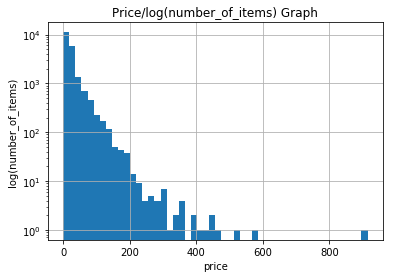

In [5]:
price.hist(log=True, bins=50)
plt.title("Price/log(number_of_items) Graph")
plt.xlabel("price")
plt.ylabel("log(number_of_items)")
plt.show()

Prices of items are mostly accumulated in the range between 0 to 400 USD.

In [6]:
zeros = np.where(price==0)
print("Number of free items: {}".format(zeros[0].size))

Number of free items: 15


In [7]:
category_counts = df_train["category_name"].value_counts()
print("Most frequent categories:")
category_counts.head(10)

Most frequent categories:


Sports & Outdoors/Exercise/Fitness accessories       3363
Sports & Outdoors/Fan Shop/NFL                       2688
Sports & Outdoors/Exercise/Fitness technology        1628
Sports & Outdoors/Outdoors/Hiking & Camping          1577
Sports & Outdoors/Fan Shop/MLB                        846
Sports & Outdoors/Fan Shop/NCAA                       805
Sports & Outdoors/Apparel/Boys                        798
Sports & Outdoors/Apparel/Accessories                 787
Sports & Outdoors/Team Sports/Baseball & Softball     524
Sports & Outdoors/Fan Shop/NBA                        508
Name: category_name, dtype: int64

Fitness related categories clearly predominates.

In [8]:
item_condition = df_train["item_condition_id"]
print("Item conditions:")
print("1: new\n2: like new\n3: good\n4: fair\n5: poor")
print("-----------------------")
print("Item condition counts:")
item_condition.value_counts()

Item conditions:
1: new
2: like new
3: good
4: fair
5: poor
-----------------------
Item condition counts:


1    9783
3    5501
2    4528
4     447
5      14
Name: item_condition_id, dtype: int64

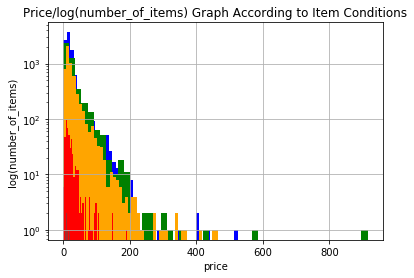

blue: new
green: like new
orange: good
red: fair
brown: poor


In [9]:
condition_colors = ['blue', 'green', 'orange', 'red', 'brown']
for i, color in enumerate(condition_colors):
    plot_df = df_train.query('item_condition_id == {}'.format(i+1))
    plot_df['price'].hist(log=True, color=color, bins=50)
plt.title("Price/log(number_of_items) Graph According to Item Conditions")
plt.xlabel("price")
plt.ylabel("log(number_of_items)")
plt.show()
print("blue: new\ngreen: like new\norange: good\nred: fair\nbrown: poor")

From new to poor conditions the longness of the graphs' tail increases. So obviously the better condition one item has, the more expensive it is. Nothing unexpected.

In [10]:
shipping_status = df_train["shipping"]
print("Shipping statuses:")
print("1: paid shipping\n2: non-paid shipping")
print("-----------------------")
print("Shipping status counts:")
shipping_status.value_counts()

Shipping statuses:
1: paid shipping
2: non-paid shipping
-----------------------
Shipping status counts:


0    11301
1     8972
Name: shipping, dtype: int64

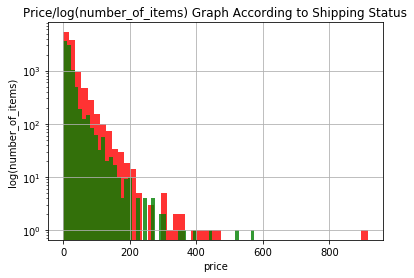

green: paid shipping
red: non-paid shipping


In [11]:
condition_colors = ['red', 'green']
for i, color in enumerate(condition_colors):
    plot_df = df_train.query('shipping == {}'.format(i))
    plot_df['price'].hist(log=True, color=color, bins=50, alpha=0.8)
plt.title("Price/log(number_of_items) Graph According to Shipping Status")
plt.xlabel("price")
plt.ylabel("log(number_of_items)")
plt.show()
print("green: paid shipping\nred: non-paid shipping")

Interestingly, number of items with non-paid shipping increases as price increase.

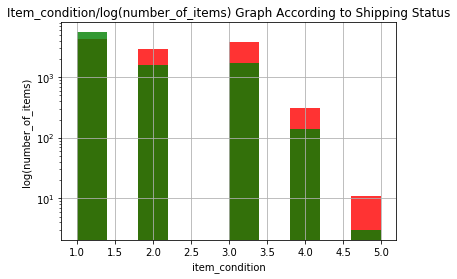

green: paid shipping
red: non-paid shipping
-----------------------
1: new
2: like new
3: good
4: fair
5: poor


In [12]:
for i, color in enumerate(condition_colors):
    plot_df = df_train.query('shipping == {}'.format(i))
    plot_df['item_condition_id'].hist(log=True, color=color, alpha=0.8)
plt.title("Item_condition/log(number_of_items) Graph According to Shipping Status")
plt.xlabel("item_condition")
plt.ylabel("log(number_of_items)")
plt.show()
print("green: paid shipping\nred: non-paid shipping")
print("-----------------------")
print("1: new\n2: like new\n3: good\n4: fair\n5: poor")

In [13]:
brand_counts = df_train["brand_name"].value_counts()
print("Most frequent brands:")
brand_counts.head(10)

Most frequent brands:


Fitbit          1629
Nike            1609
Under Armour     950
Adidas           492
Yeti             254
Reebok           251
Garmin            96
Titleist          96
Rawlings          89
Wilson            84
Name: brand_name, dtype: int64

### Expensiveness

In [14]:
expensives = df_train.copy(deep=True)
expensive_brands = expensives.groupby(['brand_name'])
print("Most expensive brands according to price median:")
expensive_brands.apply(lambda x: x["price"].median()).sort_values(ascending=False).head(10)

Most expensive brands according to price median:


brand_name
Xenith               171.0
Dunlop               140.0
Winchester           130.0
Barnett Crossbows    120.0
Hoverboard           100.0
Blitz®                95.0
Streamlight®          95.0
Adams Golf            90.0
GolfBuddy             85.0
Thule                 80.0
dtype: float64

In [15]:
expensive_categories = df_train.groupby(['category_name'])
print("Most expensive categories according to price median:")
expensive_categories.apply(lambda x: x["price"].median()).sort_values(ascending=False).head(10)

Most expensive categories according to price median:


category_name
Sports & Outdoors/Golf/Women's Golf Clubs        100.0
Sports & Outdoors/Golf/Electronics                72.0
Sports & Outdoors/Exercise/Track & Field          53.5
Sports & Outdoors/Golf/Golf Bags                  52.0
Sports & Outdoors/Golf/Men's Golf Clubs           51.0
Sports & Outdoors/Exercise/Fitness technology     45.0
Sports & Outdoors/Outdoors/Boating                35.5
Sports & Outdoors/Golf/Golf Shoes                 31.0
Sports & Outdoors/Footwear/Cleats                 31.0
Sports & Outdoors/Outdoors/Snowboard              29.0
dtype: float64

### Words inside Item Descriptions

In [16]:
download("stopwords")
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /home/ihsan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Words are count after removing stop words.

In [17]:
descriptions = df_train.copy(deep=True)
descriptions = descriptions.dropna(subset=["item_description"], how="any")
word_list = " ".join(descriptions["item_description"]).lower().split()
print("Most frequent words inside item descriptions excluding stop words:")
pd.Series([word if word not in stop_words and len(word) > 3 else None for word in word_list]).value_counts()[:10]

Most frequent words inside item descriptions excluding stop words:


size        6837
brand       3834
waist       2871
free        2845
used        2742
great       2536
[rm]        2329
black       2083
shipping    2012
never       1963
dtype: int64

## Pre-processing and Training

In [18]:
import math

import pandas as pd
import numpy as np

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import IncrementalPCA
from mlxtend.regressor import StackingRegressor
from nltk import download
from nltk.corpus import stopwords

### Preparing Data

In [19]:
y_train = df_train["price"]
y_test = df_test["price"]
df_combined = df_train.append(df_test).drop("price", axis=1)
df_combined.head()

,train_id,name,item_condition_id,category_name,brand_name,shipping,item_description
1317627,1317627,Under Armour Boys Zip Up Sweatshirt,3,Sports & Outdoors/Apparel/Boys,Under Armour,0,Size Boys Small Under Armour full zip up hoode...
1356698,1356698,Nike Strike Football Cleats,3,Sports & Outdoors/Footwear/Cleats,Nike,0,Boys Youth size 6 Nike Strike Football Cleats ...
1300098,1300098,Kids Under Armour Football Gloves,3,Sports & Outdoors/Team Sports/Football,Under Armour,0,Kids UA football gloves
282600,282600,BUNDLE,3,Sports & Outdoors/Fan Shop/NHL,NaN,0,Sharks Jacket Atlanta Thrashers Jersey Kings H...
204097,204097,Waist Trainer,1,Sports & Outdoors/Exercise/Fitness accessories,NaN,1,New still in bag. Slimming Waist Shaper Traini...


In [20]:
df_combined.isnull().any()

train_id             False
name                 False
item_condition_id    False
category_name        False
brand_name            True
shipping             False
item_description     False
dtype: bool

In [21]:
df_combined["brand_name"].fillna(value="none", inplace=True)
df_combined["item_description"].fillna(value="none", inplace=True)

### Feature extraction

Separate second level of categories to obtain a new feature ("2category" in addition to "1category/2category/3category"). Not most items has third and forth levels of categories. Thus just second level is extracted. 

In [22]:
def level_cat(x, level=1):
    try:
        levels = x.split("/")
        return levels[level]
    except IndexError:
        return None
    except AttributeError:
        return None

df_combined["{}_level_cat".format(2)] = df_combined["category_name"].apply(lambda x: level_cat(x, level=2))

Removed stopwords from both description and name of item. Features for them are only lengths. Tried to use text extraction classes of Scikit-learn (TF-IDF) but run out of memory.

In [23]:
word_count = lambda text: len([word for word in text.split(" ") if word not in stop_words and len(word) > 3])

df_combined["name_len"] = df_combined["name"].apply(word_count)
df_combined["description_len"] = df_combined["item_description"].apply(word_count)

In [24]:
df_combined = df_combined.drop(["item_description", "category_name", "name"], axis=1)
df_combined.head()

,train_id,item_condition_id,brand_name,shipping,2_level_cat,name_len,description_len
1317627,1317627,3,Under Armour,0,Boys,4,10
1356698,1356698,3,Nike,0,Cleats,4,18
1300098,1300098,3,Under Armour,0,Football,5,3
282600,282600,3,none,0,NHL,1,35
204097,204097,1,none,1,Fitness accessories,2,27


In [25]:
df_combined = pd.get_dummies(df_combined, columns=["brand_name", "2_level_cat"])
df_combined.shape

(25342, 316)

In [26]:
df_combined.head()

,train_id,item_condition_id,shipping,name_len,description_len,brand_name_5.11 Tactical,brand_name_A Bathing Ape,brand_name_AND1,brand_name_ASICS,brand_name_Abu Garcia,...,2_level_cat_Snowboard,2_level_cat_Soccer,2_level_cat_Strength training,2_level_cat_Tennis & Racquets,2_level_cat_Track & Field,2_level_cat_Volleyball,2_level_cat_Water Sports,2_level_cat_Women,2_level_cat_Women's Golf Clubs,2_level_cat_Yoga & Pilates
1317627,1317627,3,0,4,10,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1356698,1356698,3,0,4,18,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1300098,1300098,3,0,5,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
282600,282600,3,0,1,35,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
204097,204097,1,1,2,27,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Split combined data for training and prediction.

In [27]:
X_train, X_test = df_combined[:-test_count], df_combined[train_count:]

print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))
print("----------------------------")
print("Last version of X_train:")
X_train.head()

X_train shape: (20273, 316)
y_train shape: (20273,)
X_test shape: (5069, 316)
y_test shape: (5069,)
----------------------------
Last version of X_train:


,train_id,item_condition_id,shipping,name_len,description_len,brand_name_5.11 Tactical,brand_name_A Bathing Ape,brand_name_AND1,brand_name_ASICS,brand_name_Abu Garcia,...,2_level_cat_Snowboard,2_level_cat_Soccer,2_level_cat_Strength training,2_level_cat_Tennis & Racquets,2_level_cat_Track & Field,2_level_cat_Volleyball,2_level_cat_Water Sports,2_level_cat_Women,2_level_cat_Women's Golf Clubs,2_level_cat_Yoga & Pilates
1317627,1317627,3,0,4,10,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1356698,1356698,3,0,4,18,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1300098,1300098,3,0,5,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
282600,282600,3,0,1,35,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
204097,204097,1,1,2,27,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Dimensionality Reduction using Incremental PCA

Reduced dimensionality to speed up training. Used incremental PCA since other methods are running out of memory.

In [28]:
dr = IncrementalPCA(n_components=5)
dr.fit(X_train)
X_train = dr.transform(X_train)
X_test = dr.transform(X_test)

### Extra Trees Regression

Used GridSearchCV to find out which regularization parameters fit best. Used 5 fold cross validation to speed up training.

In [29]:
def gridsearchcv_report(predictor):
    print("Best parameters: {}".format(predictor.best_params_))
    print("Best score: {}".format(predictor.best_score_))

In [30]:
def error_report(err):
    print("MSE: {0}, meaning that prediction error is +/- {0} USD on average.".format(err))

In [31]:
hyperparameters = {"max_depth": [None, 15, 45], # None means no limit for max depth
                   "min_samples_split": [1., 3],
                   "min_samples_leaf": [6, 18, 34],
                   "max_leaf_nodes": [None, 15, 45], # None means no limit for max leaf nodes
                   "n_estimators": [5, 10, 15]}

et = GridSearchCV(ExtraTreesRegressor(random_state=42), hyperparameters, cv=5, scoring="neg_mean_absolute_error")
et.fit(X_train, y_train)
gridsearchcv_report(et)

Best parameters: {'max_depth': 15, 'min_samples_leaf': 6, 'max_leaf_nodes': None, 'min_samples_split': 3, 'n_estimators': 15}
Best score: -14.63606876657518


In [32]:
et = ExtraTreesRegressor(random_state=42, **et.best_params_)
et.fit(X_train, y_train)
y_pred_et = et.predict(X_test)

In [33]:
err = mean_absolute_error(y_test, y_pred_et)
error_report(err)

MSE: 14.179379773603356, meaning that prediction error is +/- 14.179379773603356 USD on average.


### Support Vector Regression

In [34]:
hyperparameters = {"C": [0.5, 1.],
                   "gamma": ["auto", 0.5, 1.]} # auto means 1/n_features

svr = GridSearchCV(SVR(), hyperparameters, cv=5, scoring="neg_mean_absolute_error")
svr.fit(X_train, y_train)
gridsearchcv_report(svr)

Best parameters: {'gamma': 'auto', 'C': 0.5}
Best score: -14.827387819143098


In [35]:
svr = SVR(**svr.best_params_)
svr.fit(X_train, y_train)
y_pred_svr = svr.predict(X_test)

In [36]:
err = mean_absolute_error(y_test, y_pred_svr)
error_report(err)

MSE: 14.38222422705145, meaning that prediction error is +/- 14.38222422705145 USD on average.


### Stacking

In [37]:
regressors = [et, svr]
hyperparameters = {"meta-svr__C": [0.5, 1.],
                   "meta-svr__gamma": ["auto", 0.5, 1.]} 

st = GridSearchCV(StackingRegressor(regressors=regressors, meta_regressor=SVR(kernel="rbf")),
                  hyperparameters, cv=5, scoring="neg_mean_absolute_error")
st.fit(X_train, y_train)
gridsearchcv_report(st)

Best parameters: {'meta-svr__gamma': 'auto', 'meta-svr__C': 0.5}
Best score: -13.644407102909181


In [38]:
meta_best_params = {}
for key in st.best_params_:
    meta_best_params[key[10:]] = st.best_params_[key]

In [39]:
st = StackingRegressor(regressors=regressors, meta_regressor=SVR(**meta_best_params))
st.fit(X_train, y_train)
y_pred_st = st.predict(X_test)

In [40]:
err = mean_absolute_error(y_test, y_pred_st)
error_report(err)

MSE: 13.293300135381172, meaning that prediction error is +/- 13.293300135381172 USD on average.


### Plotting Results

In [41]:
def plot_regs(X, y, labels, y_preds, colors):
    X_test_vis = X.ravel()
    X_test_vis = X_test_vis[X_test_vis.argsort()]
    y_test_vis = y.values[X_test_vis.argsort()]
    
    for label, y_pred, color in zip(labels, y_preds, colors):
        plt.scatter(X_test_vis, y_test_vis, color='gold', label='data')
        y_pred_vis = y_pred[X_test_vis.argsort()]
        plt.plot(X_test_vis, y_pred_vis, color=color, label=label)
        
        plt.title(label)
        plt.xlabel('Data')
        plt.ylabel('Target')
        plt.legend()
        plt.show()

Reduced dimentionality for visualisation.

In [42]:
dr = IncrementalPCA(n_components=1)
X_test_vis = dr.fit_transform(X_test)

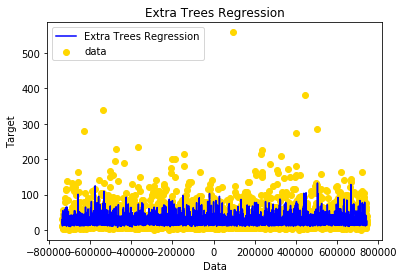

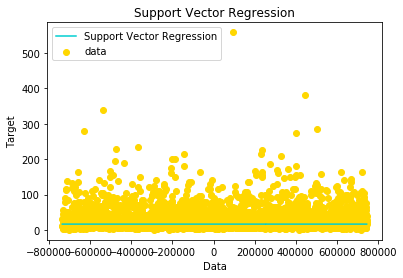

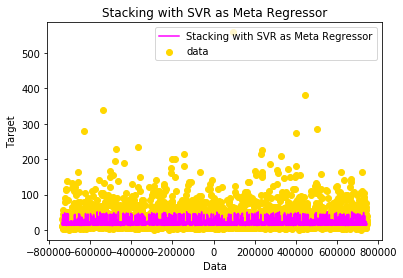

In [43]:
labels = ['Extra Trees Regression', 'Support Vector Regression', 'Stacking with SVR as Meta Regressor']
colors = ['blue', 'darkturquoise', 'magenta']
y_preds = [y_pred_et, y_pred_svr, y_pred_st]

plot_regs(X_test_vis, y_test, labels, y_preds, colors)

#### Conclusion
Tried various algorithms including Ridge Regression, Polynomial Regression, Decision Tree, Random Forest, Extra Trees and Support Vector Regressor. Pick best two and combine them using stacking method. In fact, Decision Tree is performing better than SVR. However Extra Trees and SVR are performing better in combination. Best performing blender is also SVR. 

#### What to Improve
Wıth more memory, all provided data could be used for training and descriptions of products could be analyzed in detail. Also hyperparameters of algorithms could be fine-tuned for second time. Lastly, neural nets could be applied to improve performance since it is used by the best performers of the competition.